In [9]:
from stock.transformer import StdNormalize, AmountVocab
import datetime
import pandas as pd
import numpy as np
import tqdm


df = pd.read_csv("./daily/stock_2024-12-27.csv")
cdf = pd.read_csv("stock_today.csv")
fdf = pd.read_csv("./daily/stock_fund_2024-12-27.csv")
cfdf = pd.read_csv("stock_fund_today.csv")
fdf = pd.concat([fdf,cfdf])
df = pd.concat([df,cdf])
df = df.merge(fdf)
df.dropna(inplace=True)
vnor, snor, mnor= StdNormalize(gap=5.0),StdNormalize(gap=10.0),StdNormalize(gap=25.0)
avocab = AmountVocab(df["amount"].values)
mvocab = AmountVocab(df["main_amount"].values)

def nor_feature(r,p,pg):
    amount, price  = pg["amount"].mean(), pg["close"].mean()
    price_max, price_min = pg["close"].max(), pg["close"].min()
    amount_max, amount_min = pg["amount"].max(), pg["amount"].min()
    close = snor((r.close - p.close)*100/p.close)
    _open = snor((r.open - p.close)*100/p.close)
    high = snor((r.high - p.close)*100/p.close)
    low = snor((r.low - p.close)*100/p.close)
    plow =snor((r.low - price_min)*100/price)
    phigh =snor((r.high - price_max)*100/price)
    pclose =snor((r.close - price)*100/price)
    volume = vnor(np.log2(r.amount/amount))
    vhigh = vnor(np.log2(r.amount/amount_max))
    vlow = vnor(np.log2(r.amount/amount_max))
    amount = avocab(r.amount)/10
    mamount = mvocab(r.main_amount)/10
    mpercent =mnor(r.main_percent)
    # [close,_open,high,low,volume,amount,plow,phigh, pclose,vhigh,vlow]

    return [close,_open,high,low,volume,amount,mamount, mpercent]

def make_data(df, cdate, cnum):
    codes, names, targets, features = [], [], [],[]
    for k,g in tqdm.tqdm(df.sort_values(by="date", ascending=False).groupby("code"),
                         desc=f"processing date[{cdate}]"):
        cur = g[g.date==cdate]
        g = g[g.date<cdate]
        cg, pg = g[:cnum],g[cnum:]
        row = np.zeros((cnum,8),dtype=float)
        if cg.shape[0]==cnum and pg.shape[0]>0 and cur.shape[0]>0:
            cr,pr = cur.iloc[0],cg.iloc[0]
            codes.append(cr["code"])
            names.append(cr["name"])
            change = (cr.close-pr.close)*100/pr.close
            if change>10:
                change = 10
            elif change<-10:
                change = -10
            targets.append(change/10.0)
            for i in range(cg.shape[0]):
                r, p= g.iloc[i],g.iloc[i+1]
                row[i,:] = nor_feature(r,p,pg)
            features.append(row)
        # break
    return pd.DataFrame({"date":cdate, "code":codes,"name":names,"feature":features, "target": targets})

def get_dates(cdt, days=3):
    ctm = datetime.datetime.strptime(cdt,"%Y-%m-%d")
    dts = []
    for i in range(1, days+3):
        delta = datetime.timedelta(days=-i)
        ttm = ctm+delta
        if ttm.weekday() <5:
            dts.append(ttm.strftime("%Y-%m-%d"))
    return dts[:days]
cdate, lst,hdays = "2024-12-30", [], 10
for dt in get_dates(cdate,5):
    lst.append(make_data(df,dt, hdays))
pdf = pd.concat(lst)
cdf = make_data(df, cdate, hdays)
pdf.head()


processing date[2024-12-27]: 100%|██████████| 4411/4411 [00:13<00:00, 323.88it/s]

processing date[2024-12-26]: 100%|██████████| 4411/4411 [00:13<00:00, 333.20it/s]

processing date[2024-12-25]: 100%|██████████| 4411/4411 [00:12<00:00, 348.69it/s]

processing date[2024-12-24]: 100%|██████████| 4411/4411 [00:12<00:00, 352.87it/s]

processing date[2024-12-23]: 100%|██████████| 4411/4411 [00:12<00:00, 350.80it/s]

processing date[2024-12-30]: 100%|██████████| 4411/4411 [00:12<00:00, 352.03it/s]


,date,code,name,feature,target
0,2024-12-27,sh600000,浦发银行,"[[-0.009661835748792065, 0.0, 0.03864734299516...",0.019342
1,2024-12-27,sh600004,白云机场,"[[-0.07164790174002077, 0.02047082906857684, 0...",0.164948
2,2024-12-27,sh600006,东风股份,"[[0.997191011235955, -0.028089887640450083, 0....",-0.127714
3,2024-12-27,sh600007,中国国贸,"[[-0.13815522145469317, -0.04469727752945934, ...",0.065925
4,2024-12-27,sh600008,首创环保,"[[-0.11940298507462696, 0.0, 0.029850746268656...",0.120846


In [10]:
import warnings
warnings.filterwarnings("ignore")
import torch
from stock.models import ConvBERT
from torch import nn
from torch.nn import functional as F
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader, random_split, Dataset
from lightning.pytorch.loggers import CSVLogger
logger = CSVLogger("logs", name="my_exp_name")



class StockDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return (torch.tensor(row["feature"], dtype=torch.float32),
                torch.tensor([row["target"]],dtype=torch.float32))

class BaseModel(L.LightningModule):
    def __init__(self):
        super(BaseModel, self).__init__()

    def forward(self, x):
        pass

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        return self.forward(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.forward(x)
        # print(x_hat.shape,y.shape)
        loss = F.mse_loss(x_hat, y)
        self.log("train_loss", loss)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.forward(x)
        loss = F.mse_loss(x_hat, y)
        self.log("val_loss", loss,prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.forward(x)
        loss = F.mse_loss(x_hat, y)
        self.log("test_loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer


class DailyGRU(BaseModel):
    def __init__(self):
        super().__init__()
        self.rnn = nn.GRU(8, 64,num_layers=2, batch_first=True, bidirectional=False)
        self.linear = nn.Linear(2*64, 1)
    def forward(self, x):
        bs,length  = x.shape[0], x.shape[1]
        x = x.view((bs,length,-1))
        output, hn= self.rnn(x)
        y = hn.view((bs,-1))
        y = torch.relu(y)
        ouputs = self.linear(y)
        ouputs = torch.tanh(ouputs)
        return ouputs

class TranConv(BaseModel):
    def __init__(self):
        super().__init__()
        self.model = ConvBERT(32,8,0.2,hdays)

    def forward(self, x):
        bs,length = x.shape[0], x.shape[1]
        x = x.view((bs,length,-1))
        x = self.model(x)
        ouputs = torch.tanh(x)
        return ouputs


model = TranConv()
valid_len = int(pdf.shape[0]*0.1)
train_dataset, valid_dataset = random_split(StockDataset(pdf), [len(pdf)-valid_len,valid_len])
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=32,shuffle=False)
test_loader = DataLoader(StockDataset(cdf),batch_size=32,shuffle=False)
callbacks=[EarlyStopping(monitor="val_loss", mode="min",patience=10)]
trainer = L.Trainer(limit_train_batches=100, max_epochs=50, callbacks=callbacks, logger=logger)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
trainer.test(model=model, dataloaders = test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | ConvBERT | 52.0 K | train
-------------------------------------------
52.0 K    Trainable params
0         Non-trainable params
52.0 K    Total params
0.208     Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.1940605342388153     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1940605342388153}]

In [11]:
predictions = trainer.predict(model, test_loader)
pdf = cdf.copy()
pdf["target"] = pdf["target"]*10
pdf["prediction"] = torch.concat(predictions)*10
pdf.sort_values(by="prediction",ascending=False)[:200]

Predicting: |          | 0/? [00:00<?, ?it/s]

,date,code,name,feature,target,prediction
2728,2024-12-30,sz002664,信质集团,"[[0.3047484053862507, 0.11339475549255858, 0.3...",-2.475928,7.935157
1754,2024-12-30,sz000532,华金资本,"[[0.16152716593245275, 0.03671071953010331, 0....",-0.505780,7.813432
559,2024-12-30,sh600756,浪潮软件,"[[0.20053475935828807, 0.0, 0.4344919786096247...",-1.441678,7.756378
813,2024-12-30,sh601225,陕西煤业,"[[-0.07836308228123627, 0.017414018284720376, ...",2.413339,7.618757
1935,2024-12-30,sz000821,京山轻机,"[[0.01536098310291826, -0.01536098310291826, 0...",-0.383436,7.581983
...,...,...,...,...,...,...
2748,2024-12-30,sz002688,金河生物,"[[0.35634743875278424, 0.0, 0.3786191536748328...",-2.150538,5.790660
4333,2024-12-30,sz301499,维科精密,"[[0.1828358208955218, 0.07089552238805885, 0.4...",-0.696226,5.788359
2510,2024-12-30,sz002413,雷科防务,"[[0.38548752834467104, 0.24943310657596243, 0....",-1.091703,5.786331
2351,2024-12-30,sz002235,安妮股份,"[[0.07259528130671514, -0.036297640653356764, ...",-3.243243,5.785339


MSE is: 20.27
The Pearson Correlation Coefficient is:0.00


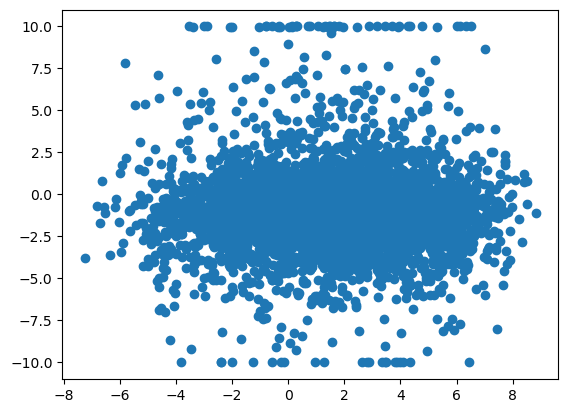

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

smse = mean_squared_error(pdf["prediction"], pdf["target"])
print(f"MSE is: {smse:.2f}")
pr = pearsonr(pdf["prediction"], pdf["target"])[0]
print(f"The Pearson Correlation Coefficient is:{pr:.2f}")
plt.scatter(pdf["prediction"], pdf["target"])
plt.show()

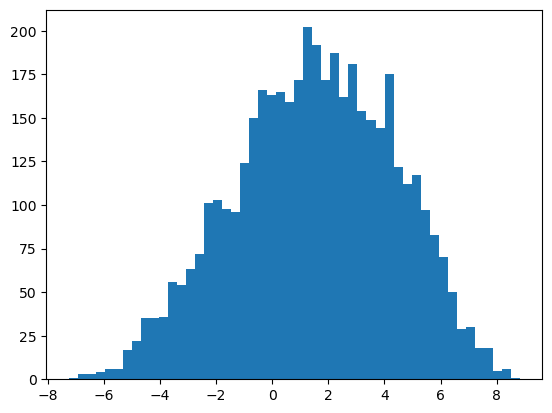

In [8]:
plt.hist(pdf["prediction"], bins=50)
plt.show()